In [1]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
from scipy.spatial.distance import cdist
from scipy import signal
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pynumdiff

#plots
import figurefirst
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()

In [2]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'

In [3]:
def boxplotfill(ax):
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('None')

In [4]:
def set_grid_false(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.grid(False)

In [5]:
def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)
    osm.encounter_frequency(df,index,fdf)
    osm.mean_avg(df,index,fdf)

In [ ]:
def results_summary_to_dataframe(results):
    whiff = []
    ma = []
    encounterFrequency= []
    blanks = []
    rsquared = [] 

    for i in range (len(results)):

        whiff.append(results[i].pvalues.whiffs_resid)
        ma.append(results[i].pvalues.movingavg_resid)
        encounterFrequency.append(results[i].pvalues.encounterfreq_resid)
        blanks.append(results[i].pvalues.blanks_resid)
        rsquared.append(results[i].rsquared)

    results_df = pd.DataFrame({"rsquared":rsquared, 
                              "p_whiff_length":whiff,
                              "p_encounter_frequency":encounterFrequency,
                              "p_moving_avg":ma,
                              "p_blanks":blanks
                              })

    #Reordering...
    results_df = results_df[["rsquared","p_whiff_length","p_encounter_frequency","p_moving_avg","p_blanks"]]
    results_df.to_hdf(dir+'R2AngleChangesNotWindy.h5', key='results_df', mode='w')



In [6]:
# df = pd.read_hdf(dir+'NotWindy/NotWindyIF.h5')
# df = pd.read_hdf(dir+'Windy/WindyIF.h5')
# df = pd.read_hdf(dir+'ContinuousWindyIF.h5')

2021-12-06 15:29:57,153 [INFO] Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-12-06 15:29:57,154 [INFO] NumExpr defaulting to 8 threads.


In [87]:
# ## load files and convert to stats 

# data = []
# run = [2,4,8,10,20,30,40,50,60,80]
# for i in range(len(run)):
#     fname = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/NotWindy/LW'+str(run[i])+'Hz.h5'
#     df = pd.read_hdf(fname)
#     index = osm.get_index_filtered(df)
#     fdf =pd.DataFrame()
#     get_statistics(df,index,fdf)
#     fdf.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/NotWindy/LW'+str(run[i])+'HzStats.h5', key='fdf', mode='w')



In [88]:
# run = [2,4,8,10,20,30,40,50,60,80]

# rdf=pd.DataFrame()
# for j in range(len(run)):
#     df = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/NotWindy/LW'+str(run[j])+'HzStats.h5')
#     rsquared=[]
#     for i in range (200):
#         dfs = fdf.loc[fdf.sample(n=500).index]
#         dfs.reset_index(inplace=True, drop=True)
#         model = osm.get_distance_statsmodel(dfs)
#         rsquared.append(model.rsquared)
#     rdf[str(run[j])] = rsquared
    
# rdf.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/NotWindy/LWBS.h5', key='rdf', mode='w')

In [151]:
rdf = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/Windy/HWBS.h5')

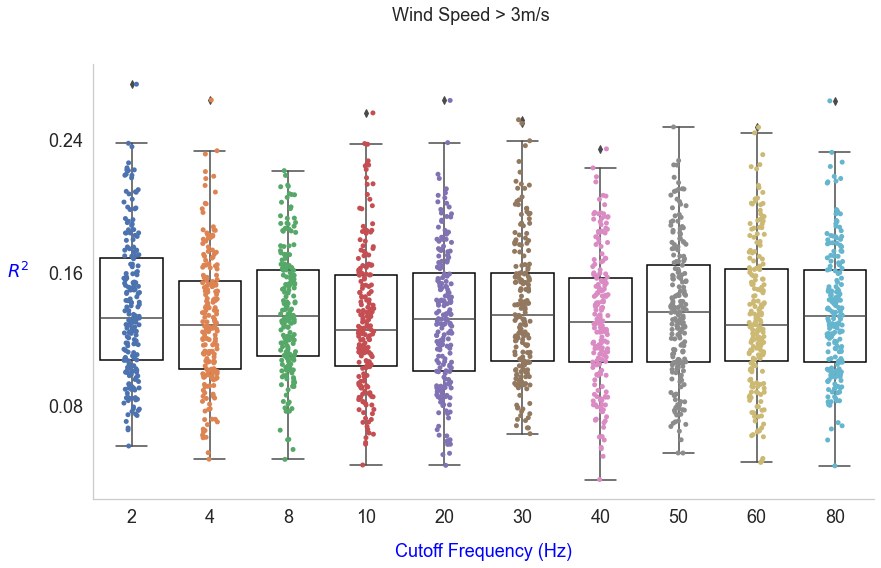

In [153]:
f, ax  = plt.subplots(1,1, figsize=(14,8))
sns.set_style("whitegrid")
ax.grid(False)
sns.boxplot(data=rdf , ax = ax)
boxplotfill(ax)
sns.stripplot(data=rdf, ax = ax)
ax.set_xlabel('Cutoff Frequency (Hz)', color = 'blue')
ax.set_ylabel('$R^2$', rotation = 0, color = 'blue')
ax.yaxis.set_label_coords(-0.095, 0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
f.suptitle('Wind Speed > 3m/s')
figurefirst.mpl_functions.set_fontsize(f, 18)
# f.savefig('../../Figure/Bootstrap_R2_HW.jpeg') 

In [101]:
pd.set_option('use_inf_as_na', True) ## for excluding negative infinity and NaN values 

In [102]:
fdf=osm.sort_by_distance(fdf)

In [103]:
logwhiff=smf.ols(formula=' avg_dist_from_source ~ log_whiff', data=fdf).fit()
ef=smf.ols(formula=' avg_dist_from_source ~ mean_encounter_frequency', data=fdf).fit()
ma=smf.ols(formula=' avg_dist_from_source ~ mean_ma', data=fdf).fit()
logblank=smf.ols(formula=' avg_dist_from_source ~ log_blank', data=fdf).fit()

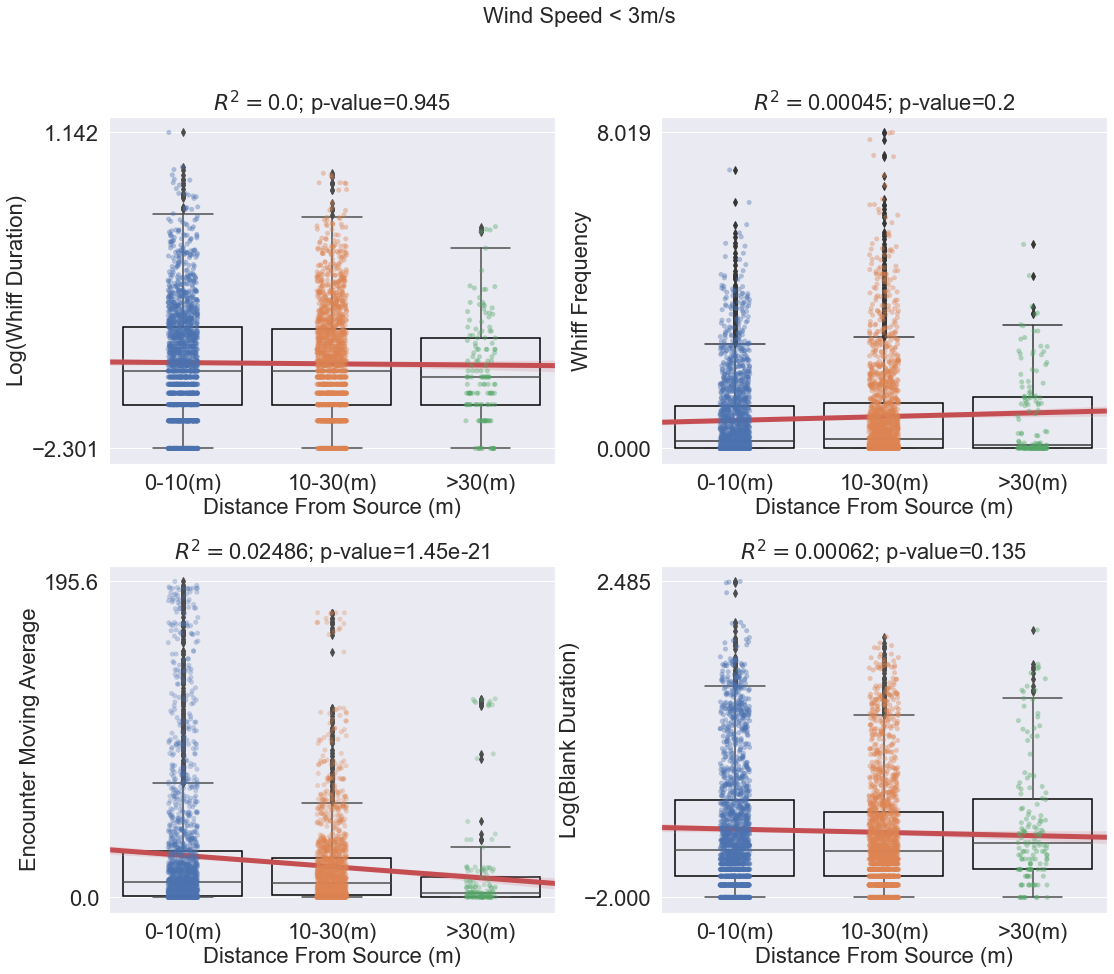

In [104]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(16,14)
                    ,gridspec_kw={'height_ratios':[1,1],'width_ratios': [1,1]})
## Log(Lenght of Whiffs)
sns.boxplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf,  dodge=True,  ax=ax1 )
boxplotfill(ax1)
sns.stripplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf, dodge='True', ax=ax1, alpha=0.4)
sns.regplot(x="bins_distance",y="log_whiff", data=fdf, 
            ax=ax1, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)


ax1.set_xlabel('Distance From Source (m)')
ax1.set_ylabel('Log(Whiff Duration)')
ax1.set_title('$R^2=$'+str(np.round(logwhiff.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(logwhiff.pvalues.log_whiff)))
ax1.set_yticks([fdf.log_whiff.min(),fdf.log_whiff.max()])

## Whiff Frequency
sns.boxplot(x="distance_from_source_bin", y="mean_encounter_frequency", 
            data=fdf,  dodge=True,  palette='viridis',ax=ax2 )
boxplotfill(ax2)    
sns.stripplot(x="distance_from_source_bin", y="mean_encounter_frequency", 
            data=fdf, dodge='True', ax=ax2, alpha=0.4)
sns.regplot(x="bins_distance",y="mean_encounter_frequency", data=fdf, 
            ax=ax2, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)
# ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.set_xlabel('Distance From Source (m)')
ax2.set_ylabel('Whiff Frequency')
ax2.set_yticks([fdf.mean_encounter_frequency.min(),fdf.mean_encounter_frequency.max()])
ax2.set_title('$R^2=$'+str(np.round(ef.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(ef.pvalues.mean_encounter_frequency)))

#Intermittency Factor
sns.stripplot(x="distance_from_source_bin", y="mean_ma", 
            data=fdf, dodge='True', ax=ax3, alpha=0.3)
sns.boxplot(x="distance_from_source_bin", y="mean_ma", 
            data=fdf,  dodge=True, ax=ax3 )
boxplotfill(ax3)
sns.regplot(x="bins_distance",y="mean_ma", data=fdf, 
            ax=ax3, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax3.set_yticks([fdf.mean_ma.min(),fdf.mean_ma.max()])
ax3.set_xlabel('Distance From Source (m)')
ax3.set_ylabel('Encounter Moving Average')
ax3.set_title('$R^2=$'+str(np.round(ma.rsquared,5)) 
            +'; p-value='+ str('{:.3g}'.format(ma.pvalues.mean_ma)))



#Blank Frequency
sns.stripplot(x="distance_from_source_bin", y="log_blank", 
            data=fdf, dodge='True',alpha=0.4, ax=ax4)
sns.boxplot(x="distance_from_source_bin", y="log_blank", 
            data=fdf,  dodge=True, ax=ax4 )
boxplotfill(ax4)
sns.regplot(x="bins_distance",y="log_blank", data=fdf, 
            ax=ax4, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax4.set_yticks([fdf.log_blank.min(),fdf.log_blank.max()])
ax4.set_xlabel('Distance From Source (m)')
ax4.set_ylabel('Log(Blank Duration)')
ax4.set_title('$R^2=$'+str(np.round(logblank.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(logblank.pvalues.log_blank)))


f.suptitle('Wind Speed < 3m/s', fontsize='large')
f.tight_layout(pad=4.0)
figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/LW.jpeg') 
# f.savefig('../../Figure/removeddisc.svg', format='svg',dpi=1200)

In [84]:
encounter_freq=smf.ols(formula='mean_encounter_frequency ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
encounters=smf.ols(formula='log_whiff~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
intermittencies=smf.ols(formula='log_blank ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()
intermittencyfact = smf.ols(formula='mean_ma ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()
# print(intermittencyfact.summary())

In [85]:
fdf['encounterfreq_resid']=encounter_freq.resid
fdf['encounter_resid'] = encounters.resid
fdf['intermittency_resid'] = intermittencies.resid
fdf['intermittencyfact_resid'] = intermittencyfact.resid

In [86]:
whiffresid=smf.ols(formula=' avg_dist_from_source ~ encounter_resid', data=fdf).fit()
efresid=smf.ols(formula=' avg_dist_from_source ~ encounterfreq_resid', data=fdf).fit()
maresid=smf.ols(formula=' avg_dist_from_source ~ intermittencyfact_resid', data=fdf).fit()
logblankresid=smf.ols(formula=' avg_dist_from_source ~ intermittency_resid', data=fdf).fit()

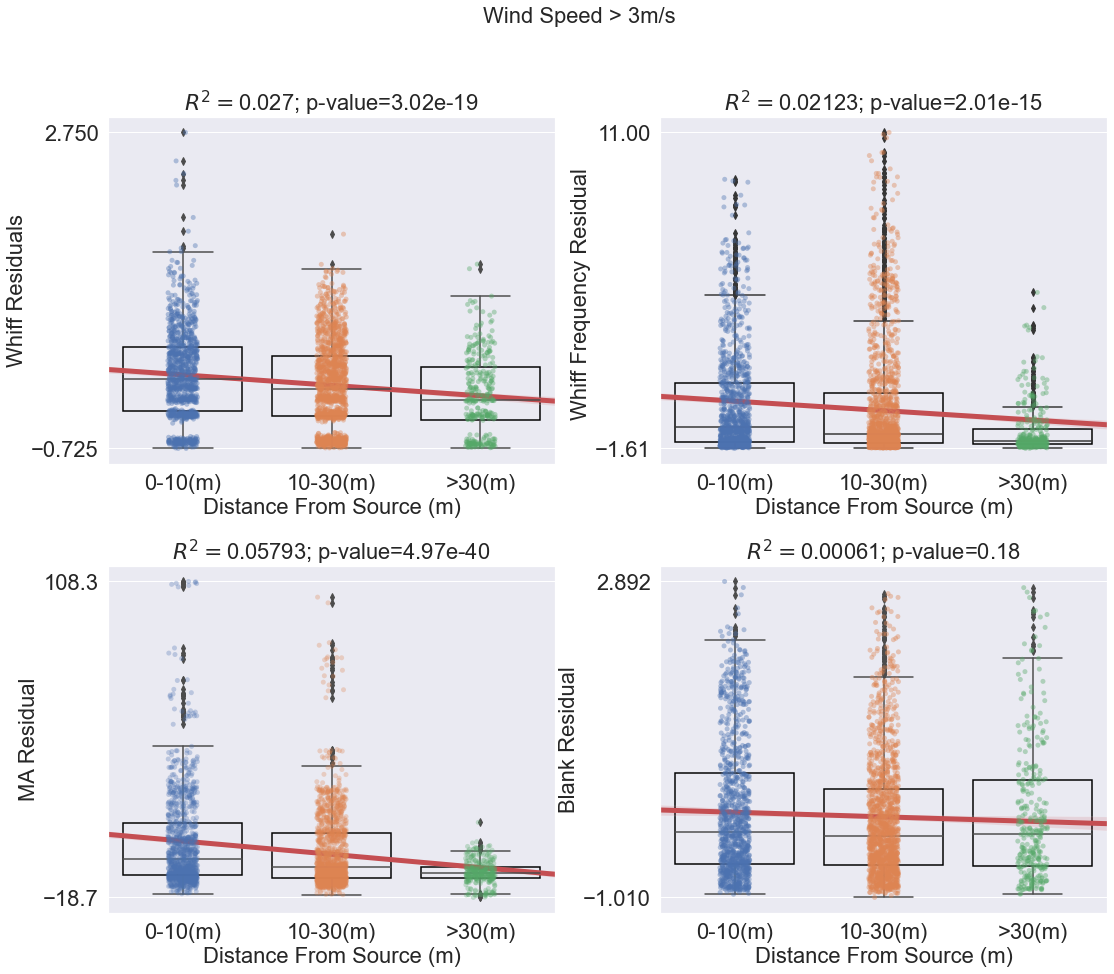

In [87]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(16,14)
                    ,gridspec_kw={'height_ratios':[1,1],'width_ratios': [1,1]})
## Log(Lenght of Whiffs)
sns.boxplot(x="distance_from_source_bin", y="encounter_resid", 
            data=fdf,  dodge=True,  ax=ax1 )
boxplotfill(ax1)
sns.stripplot(x="distance_from_source_bin", y="encounter_resid", 
            data=fdf, dodge='True', ax=ax1, alpha=0.4)
sns.regplot(x="bins_distance",y="encounter_resid", data=fdf, 
            ax=ax1, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)


ax1.set_xlabel('Distance From Source (m)')
ax1.set_ylabel('Whiff Residuals')
ax1.set_title('$R^2=$'+str(np.round(whiffresid.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(whiffresid.pvalues.encounter_resid)))
ax1.set_yticks([fdf.encounter_resid.min(),fdf.encounter_resid.max()])

## Whiff Frequency
sns.boxplot(x="distance_from_source_bin", y="encounterfreq_resid", 
            data=fdf,  dodge=True,  palette='viridis',ax=ax2 )
boxplotfill(ax2)    
sns.stripplot(x="distance_from_source_bin", y="encounterfreq_resid", 
            data=fdf, dodge='True', ax=ax2, alpha=0.4)
sns.regplot(x="bins_distance",y="encounterfreq_resid", data=fdf, 
            ax=ax2, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)
# ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.set_xlabel('Distance From Source (m)')
ax2.set_ylabel('Whiff Frequency Residual ')
ax2.set_yticks([fdf.encounterfreq_resid.min(),fdf.encounterfreq_resid.max()])
ax2.set_title('$R^2=$'+str(np.round(efresid.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(efresid.pvalues.encounterfreq_resid)))

#Intermittency Factor
sns.stripplot(x="distance_from_source_bin", y="intermittencyfact_resid", 
            data=fdf, dodge='True', ax=ax3, alpha=0.3)
sns.boxplot(x="distance_from_source_bin", y="intermittencyfact_resid", 
            data=fdf,  dodge=True, ax=ax3 )
boxplotfill(ax3)
sns.regplot(x="bins_distance",y="intermittencyfact_resid", data=fdf, 
            ax=ax3, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax3.set_yticks([fdf.intermittencyfact_resid.min(),fdf.intermittencyfact_resid.max()])
ax3.set_xlabel('Distance From Source (m)')
ax3.set_ylabel('MA Residual')
ax3.set_title('$R^2=$'+str(np.round(maresid.rsquared,5)) 
            +'; p-value='+ str('{:.3g}'.format(maresid.pvalues.intermittencyfact_resid)))



#Blank Frequency
sns.stripplot(x="distance_from_source_bin", y="intermittency_resid", 
            data=fdf, dodge='True',alpha=0.4, ax=ax4)
sns.boxplot(x="distance_from_source_bin", y="intermittency_resid", 
            data=fdf,  dodge=True, ax=ax4 )
boxplotfill(ax4)
sns.regplot(x="bins_distance",y="intermittency_resid", data=fdf, 
            ax=ax4, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax4.set_yticks([fdf.intermittency_resid.min(),fdf.intermittency_resid.max()])
ax4.set_xlabel('Distance From Source (m)')
ax4.set_ylabel('Blank Residual')
ax4.set_title('$R^2=$'+str(np.round(logblankresid.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(logblankresid.pvalues.intermittency_resid)))


f.suptitle('Wind Speed > 3m/s', fontsize='large')

f.tight_layout(pad=4.0)
figurefirst.mpl_functions.set_fontsize(f, 22)
f.savefig('../../Figure/ResidualHW.jpeg') 

In [93]:
distance=smf.ols(formula='avg_dist_from_source ~ log_whiff + mean_ma + mean_encounter_frequency', data=fdf).fit()
print(distance.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_dist_from_source   R-squared:                       0.107
Model:                              OLS   Adj. R-squared:                  0.106
Method:                   Least Squares   F-statistic:                     116.9
Date:                  Thu, 02 Dec 2021   Prob (F-statistic):           1.74e-71
Time:                          11:06:05   Log-Likelihood:                -11131.
No. Observations:                  2941   AIC:                         2.227e+04
Df Residuals:                      2937   BIC:                         2.229e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Inte

In [91]:
distance=smf.ols(formula='avg_dist_from_source ~ encounter_resid + encounterfreq_resid + intermittencyfact_resid', data=fdf).fit()
print(distance.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_dist_from_source   R-squared:                       0.084
Model:                              OLS   Adj. R-squared:                  0.083
Method:                   Least Squares   F-statistic:                     90.24
Date:                  Thu, 02 Dec 2021   Prob (F-statistic):           7.33e-56
Time:                          11:05:45   Log-Likelihood:                -11167.
No. Observations:                  2941   AIC:                         2.234e+04
Df Residuals:                      2937   BIC:                         2.237e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Interc

In [ ]:
# ## BootStrapping Results for Distance ~ Odor Statistics

# sns.set_style('whitegrid')
# f, ((ax1,ax2,ax3,ax4)) = plt.subplots(4,1, figsize=(16,14))
# ax1.plot(rdf.angles,rdf.rsquared)
# ax1.set_yticks([rdf.rsquared.min(), rdf.rsquared.max()])
# ax1.set_ylabel('$R^2$', rotation = 0, color='blue')
# set_grid_false(ax1)
# ax1.yaxis.set_label_coords(-0.04,0.45)
# ax1.axes.get_xaxis().set_visible(False)

# ax2.plot(rdf.angles,rdf.p_whiff_length)
# ax2.set_yticks([rdf.p_whiff_length.min(), rdf.p_whiff_length.max()])
# ax2.set_ylabel('$p-value$\nWhiff Duration', rotation = 0, color='blue')
# set_grid_false(ax2)
# ax2.yaxis.set_label_coords(-0.08,0.4)
# ax2.axes.get_xaxis().set_visible(False)

# ax3.plot(rdf.angles, rdf.p_encounter_frequency)
# ax3.set_yticks([rdf.p_encounter_frequency.min(),rdf.p_encounter_frequency.max()])
# ax3.set_ylabel('$p-value$\nEncounter Frequency', rotation = 0, color='blue')
# set_grid_false(ax3)
# ax3.yaxis.set_label_coords(-0.1,0.4)
# ax3.axes.get_xaxis().set_visible(False)

# ax4.plot(rdf.angles, rdf.p_moving_avg)
# ax4.set_yticks([rdf.p_moving_avg.min(),rdf.p_moving_avg.max()])
# ax4.set_xticks([45, 50, 55, 60, 65, 70, 75, 80, 85, 90])
# ax4.set_ylabel('$p-value$\nMoving Average', rotation = 0, color='blue')
# set_grid_false(ax4)
# ax4.yaxis.set_label_coords(-0.08,0.4)
# ax4.set_xlabel('Change in Direction', color='blue')

# f.suptitle('Wind Speed < 3m/s\nDistance ~ Odor-Statistics', fontsize='medium')
# f.tight_layout(pad=4)
# figurefirst.mpl_functions.set_fontsize(f, 18)
# # f.savefig('../../Figure/changeInDirNotWindy.jpeg', dpi=1000) 
# # f.savefig('../../Figure/removeddisc.svg', format='svg',dpi=1200)